##  Chapter 11: Linear unsupervised learning

# 11.3  Feature scaling via PCA sphereing

In Sections 8.4, 9.4, and 10.3 we have seen how *feature scaling* via *standard normalization* - i.e., by subtracting off the mean of each input feature and dividing off its standard deviation - significantly improves the topology of a supervised learning cost function enabling much more rapid minimization via e.g., gradient descent.  In this Section we describe how PCA is used to perform an advanced form of standard normalization - commonly called *PCA sphereing*.  In short with this normalization technique we first employ PCA to determine a dataset's $K = N$ principal components or largest perpendicular directions of variance, rotate the dataset into its *PCA transformed space* (such that these principal components align with the coordinates of the space), and then divide off the standard deviation along each input dimension.  In dividing off the standard deviation along each of the dataset's perpendicular directions of variance we can in general compress it much more, resulting in a cost function that is even easier to optimize than the one our standard normalization technique provides.

In [1]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ortho_group  # Requires version 0.18 of scipy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
from mlrefined_libraries import basics_library as baslib
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'
normalizers = unsuplib.normalizers

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  Feature scaling by PCA sphereing

Previously in Sections 8.4, 9.4, and 10.3 we have seen with linear regression / classification how normalizing a dataset - by subtracting off the mean and dividing by the standard deviation along each of its input dimensions - helps dramatically improve the topology or contours of a cost function, allowing gradient descent (and coordinate descent) to converge much faster than they typically would otherwise.

The spanning set provided by Principal Component Analysis is often used to perform this sort of normalization to supervised learning data as well - but actually goes one step further.  Because the principal components identify the orthogonal directions of greatest variance, and the transformed feature space provided by them is a perfect copy of our data rotated such that these directions align with the coordinate axes, normalizing the transformed feature space along each coordinate axes can better compact-ify our data.  For the same reasons as we have seen with the standard normalization scheme, this can greatly improve the convergence of gradient / coordinate descent.  This type of normalization - which again is used very often for supervised learning problems - is called *sphereing* (or also synonymously called *whitening*).

Since each data point is represented by $\hat{\mathbf{w}}_p = \mathbf{V}_{\,}^T\mathbf{x}_p^{\,}$ in the space spanned by the principal components, we can represent the entire set of transformed data as 

\begin{equation}
\text{(PCA transformed data)}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\mathbf{W} = \mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

Now we aim to normalize each column of the transformed data $\mathbf{W}$.  Since these transformed features were built from a mean-centered dataset the columns of $\mathbf{W}$ are mean-centered themselves, so all that remains is to divide off the standard deviation of each column.  

This can be done in the typical way numerically - or to save computation we can conveniently the unnormalized variance of each column of $\mathbf{W}$ has already been computed in the eigen-decomposition of the regularized covariance matrix $\frac{1}{P}\mathbf{X}^{\,}\mathbf{X}^T + \lambda \mathbf{I}_{N\times N}$: these are precisely the eigenvalues (as mentioned in the derivation above).  In other word, since $d_n$ is the variance along the $n^{th}$ axis defined by the $n^{th}$ eigenvector $\mathbf{v}_n$ the corresponding standard deviation can be computed as its square root $\left(d_n\right)^{^1/_2}$.  So denoting $\mathbf{D}^{-^1/_2}$ the diagonal matrix whose $n^{th}$ entry is $\left(d_n\right)^{^1/_2}$, we can divide off the standard deviation each column of $\mathbf{W}$ by e.g.,
 left-multiplying by as

\begin{equation}
\text{(PCA-sphered data)}\,\,\,\,\,\,\,\,\, \mathbf{S}^{\,} = \mathbf{D}^{-^1/_2}\mathbf{W}^{\,} =  \mathbf{D}^{-^1/_2}\mathbf{V}^T\mathbf{X}^{\,}.
\end{equation}

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/pca_sphereing.png' width="200%"  height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> PCA-sphereing illustrated. </em>  </figcaption> 
</figure>

Once sphered notice that - as indicated in the figure - that 

- the data has been rotated such that the orthogonal directions of greatest variance now align with the coordinate axes

- our standard normalization (division by the standard deviation) is then performed along each axis

- after being PCA-sphered the data has unit-length covariance along each transformed input dimension: i.e., $\frac{1}{P}\mathbf{S}^{\,}\mathbf{S}^T = \mathbf{I}_{N\times N}$

A ``Python`` function for performing sphereing - based off the functionality previously provided - is below. 

In [2]:
def PCA_sphere(X,**kwargs):
    '''
    A function for producing the full PCA sphereing on an input dataset X.  
    '''
    # create instance of normalizers - for standard normalization and PCA transform
    calc = normalizers.My_Normalizers()
    
    # standard normalize data
    normalizer,inverse_normalizer = calc.standard(X)
    X = normalizer(X)
    
    # compute principal components 
    D,V = calc.PCA(X)
    
    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    D_ = np.array([1/d**(0.5) for d in D])
    D_ = np.diag(D_)
    S = np.dot(D_,W)
    return X,V,W,S

#### <span style="color:#a50e3e;">Example 1: </span>  Sphereing a simple unlabeled dataset

With this function defined we can try it out on a simple dataset used in e.g., example 2 of the previous Section.  The next cell runs the sphereing code above, and plots comparisons of the a) the original mean-centered data (left panel), b) the PCA-transformed data (middle panel), and c) sphered data (right panel).  Here sphereing drastically improved the distribution of the original dataset, which (if this were a supervised learning dataset) will drastically improve our ability to quickly tune the parameters of a supervised model via gradient / coordinate descent.

<IPython.core.display.Javascript object>


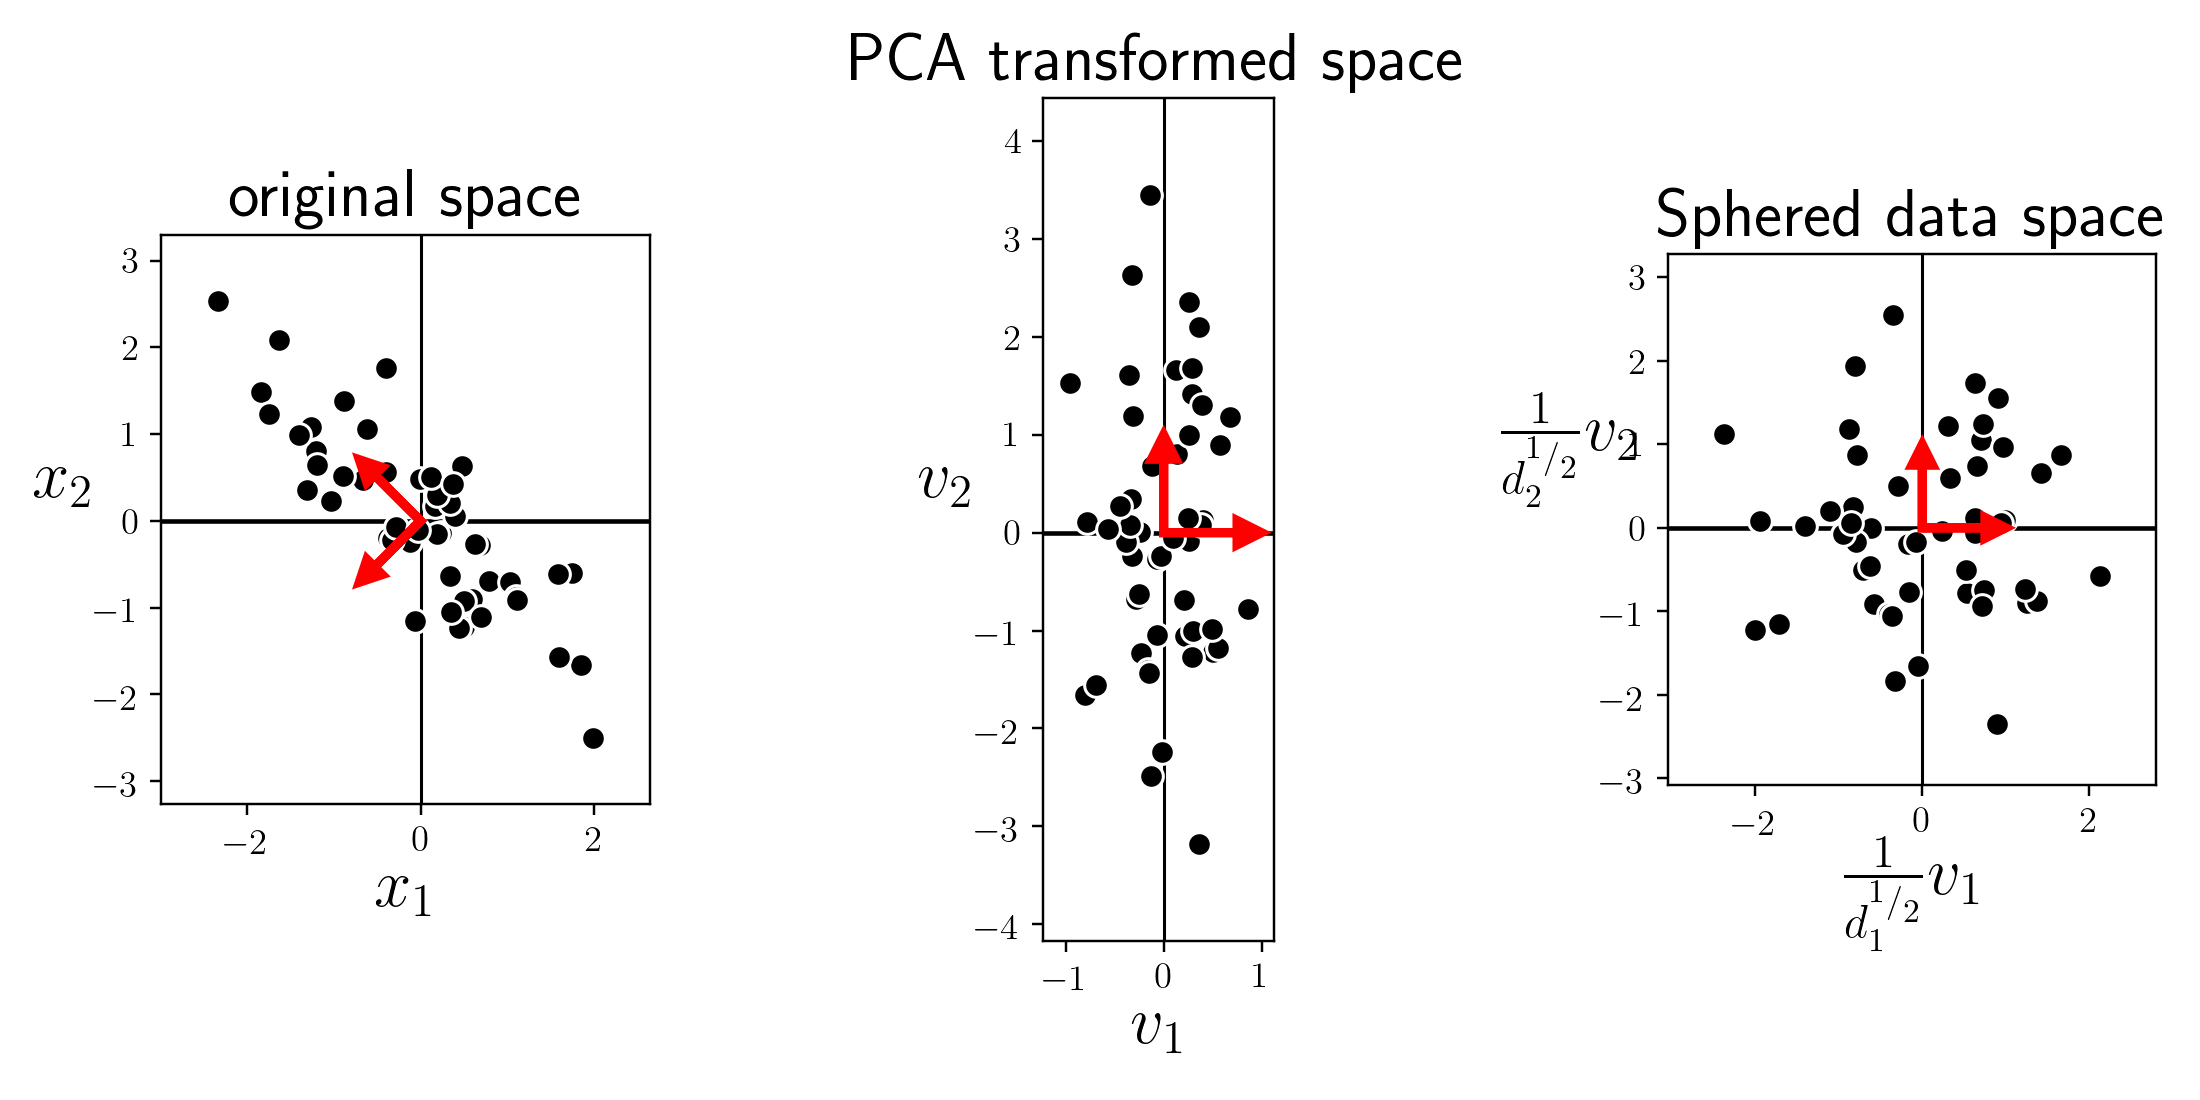

In [3]:
# load in dataset to perform PCA on
X_original = np.loadtxt(datapath + '2d_span_data.csv',delimiter=',')

# compute the full PCA transformation of dataset
X,V,W,S = PCA_sphere(X_original)

# compute principal components
unsuplib.PCA_demos.sphereing_visualizer(X,V,W,S)

In [61]:
demo = normalizers.My_Normalizers()

In [62]:
normalizer,inverse_normalizer = demo.PCA_sphereing(X_original)
X_sphered = normalizer(X_original)

In [63]:
np.linalg.norm(S - X_sphered,'fro')

1.1854255434498532e-15

In [64]:
X_reversed = inverse_normalizer(X_sphered)

In [65]:
np.linalg.norm(X_original - X_reversed,'fro')

4.2941382906866367e-15